In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.utils import plot_model
from scipy.spatial.distance import cdist, cosine
import matplotlib.pyplot as plt
from tensorboard.plugins import projector

2023-02-06 09:50:18.094959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 09:50:18.267925: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-06 09:50:19.251544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-06 09:50:19.251726: W tensorfl

In [2]:
df = pd.read_csv('Cleaned_Data/player_cleaned_encoded.csv')
df

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,0,158023,L. Messi,CF,93,95,100500000.0,550000.0,27,169,...,0,0,3,5,0,1,0,1,1,0
1,1,20801,Cristiano Ronaldo,"LW, LM",92,92,79000000.0,375000.0,29,185,...,0,0,5,4,0,0,0,1,1,0
2,2,9014,A. Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,180,...,0,0,2,5,1,-1,0,2,1,0
3,3,41236,Z. Ibrahimović,ST,90,90,52500000.0,275000.0,32,195,...,0,0,5,4,0,1,0,1,1,0
4,5,41,Iniesta,"CM, LW",89,89,36000000.0,250000.0,30,170,...,0,0,5,4,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,19234,261962,Song Defu,CDM,47,52,70000.0,1000.0,22,180,...,0,0,5,3,0,0,0,0,0,0
126284,19235,262040,C. Porter,CM,47,59,110000.0,500.0,19,175,...,0,0,5,3,0,0,0,0,0,0
126285,19236,262760,N. Logue,CM,47,55,100000.0,500.0,21,178,...,0,0,5,3,0,0,0,0,0,0
126286,19237,262820,L. Rudden,ST,47,60,110000.0,500.0,19,173,...,0,0,5,3,0,0,0,0,0,0


In [3]:
### Try different feature set

all_columns = ['sofifa_id', 'short_name', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 
           'age', 'height_cm', 'weight_kg', 'club_name', 'league_name', 'league_level', 'club_position', 'nationality_name', 
           'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'player_tags', 
           'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
           'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
           'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
           'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
           'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
           'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
           'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
           'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed', 
           'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
           'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 
           'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 
           'gk', 'season', 'diff', 
           'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot', 
           'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser', 'Takes Finesse Free Kicks', 
           'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot', 'Long Passer', 'Set Play Specialist', 'Chip Shot', 
           'Diver', 'Team Player', 'Injury Free', 'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 
           'Long Shot Taker', 'Long Throw-in', 'Backs Into Player', 'Target Forward', 'Speedster', 'Complete Defender', 'Dribbler', 
           'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 'Complete Midfielder', 'Engine', 
           'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter', 'Strength', 
           'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky', 'body_Unique', 'right_foot', 'left_foot', 
           'injury_risk', 'teamwork', 'passing_traits', 'attacking_traits', 'dribbling_traits', 'defending_traits']

### selected columns
columns = ['overall', 'potential', 
           #'age', 'height_cm', 'weight_kg', 'league_level', 
           'height_cm', 'weight_kg',
           'skill_moves', #'international_reputation', 
           'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 
           'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
           'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 
           'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 
           'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
           'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
           'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 
           'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 
           'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 
           'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 
           #### Traits
           'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot', 
           'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser', 'Takes Finesse Free Kicks', 
           'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot', 'Long Passer', 'Set Play Specialist', 'Chip Shot', 
           'Diver', 'Team Player', 'Injury Free', 'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 
           'Long Shot Taker', 'Long Throw-in', 'Backs Into Player', 'Target Forward', 
           #### Tags (Remove)
           #'Speedster', 'Complete Defender', 'Dribbler', 
           #'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 'Complete Midfielder', 'Engine', 
           #'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter', 'Strength', 
           
           #### Newly created
           'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky', 'body_Unique', 'right_foot', 'left_foot', 
           'injury_risk', 'teamwork', 'passing_traits', 'attacking_traits', 'dribbling_traits', 'defending_traits']

In [4]:
df[columns]

,overall,potential,height_cm,weight_kg,skill_moves,pace,shooting,passing,dribbling,defending,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,93,95,169,67,4,93.0,89.0,86.0,96.0,27.0,...,0,0,3,5,0,1,0,1,1,0
1,92,92,185,80,5,93.0,93.0,81.0,91.0,32.0,...,0,0,5,4,0,0,0,1,1,0
2,90,90,180,80,4,93.0,86.0,83.0,92.0,32.0,...,0,0,2,5,1,-1,0,2,1,0
3,90,90,195,95,4,76.0,91.0,81.0,86.0,34.0,...,0,0,5,4,0,1,0,1,1,0
4,89,89,170,65,4,75.0,72.0,89.0,91.0,59.0,...,0,0,5,4,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,47,52,180,64,2,58.0,35.0,46.0,48.0,42.0,...,0,0,5,3,0,0,0,0,0,0
126284,47,59,175,70,2,59.0,39.0,50.0,46.0,41.0,...,0,0,5,3,0,0,0,0,0,0
126285,47,55,178,72,2,60.0,37.0,45.0,49.0,41.0,...,0,0,5,3,0,0,0,0,0,0
126286,47,60,173,66,2,68.0,46.0,36.0,48.0,15.0,...,0,0,5,3,0,0,0,0,0,0


In [5]:
### Train test Split
X = df[columns].copy()
# Target
y = df['overall']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train.shape

(107344, 111)

In [8]:
emb_dim = 20
input = tf.keras.layers.Input(shape=X_train.shape[1:])

encoder = tf.keras.layers.Dense(X_train.shape[1:][0], activation='relu')(input)
encoder = tf.keras.layers.Dense(100, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(75, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(50, activation='relu')(encoder)
embedding = tf.keras.layers.Dense(emb_dim, activation='relu',name='embedding')(encoder)

decoder = tf.keras.layers.Dense(50, activation='relu')(embedding)
decoder = tf.keras.layers.Dense(75, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(100, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')(decoder),

autoencoder = Model(input, decoder)

autoencoder.compile(loss='mae', optimizer='adam')
autoencoder.summary()

2023-02-06 09:50:24.513520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 09:50:24.525107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 09:50:24.526890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111)]             0         
                                                                 
 dense (Dense)               (None, 111)               12432     
                                                                 
 dense_1 (Dense)             (None, 100)               11200     
                                                                 
 dense_2 (Dense)             (None, 75)                7575      
                                                                 
 dense_3 (Dense)             (None, 50)                3800      
                                                                 
 embedding (Dense)           (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 50)                1050  

2023-02-06 09:50:24.529681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 09:50:24.530701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 09:50:24.532559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 09:50:24.534385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

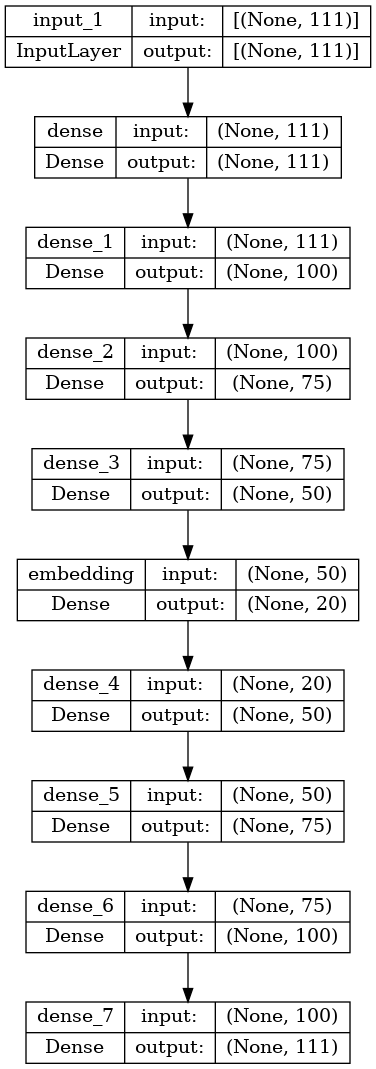

In [9]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='autoencoder.png')

In [10]:
callback = EarlyStopping(monitor='loss', patience=3)

history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False, 
                callbacks=[callback], validation_data = (X_test, X_test))

Epoch 1/100
3355/3355 [==============================] - 13s 3ms/step - loss: 0.0522 - val_loss: 0.0449
Epoch 2/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0393 - val_loss: 0.0364
Epoch 3/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0354 - val_loss: 0.0348
Epoch 4/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0337 - val_loss: 0.0331
Epoch 5/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0329 - val_loss: 0.0331
Epoch 6/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0323 - val_loss: 0.0323
Epoch 7/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0319 - val_loss: 0.0319
Epoch 8/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0315 - val_loss: 0.0321
Epoch 9/100
3355/3355 [==============================] - 11s 3ms/step - loss: 0.0311 - val_loss: 0.0311
Epoch 10/100
3355/3355 [==============================] - 11s 3m

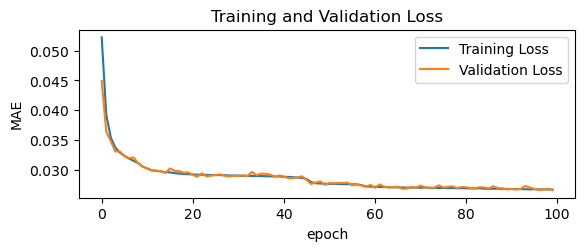

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MAE')
#plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
player_embedding = Model(input, embedding)

test = player_embedding.predict(X_test)
test

592/592 [==============================] - 1s 1ms/step


array([[1.2464712 , 0.        , 0.45178246, ..., 0.        , 4.0257263 ,
        0.        ],
       [1.1262751 , 0.        , 2.0919213 , ..., 0.        , 0.9633666 ,
        0.        ],
       [0.46669823, 0.        , 0.5353195 , ..., 0.        , 2.488021  ,
        0.        ],
       ...,
       [1.7178695 , 0.        , 0.8574031 , ..., 0.        , 1.3556777 ,
        0.        ],
       [1.4615319 , 0.        , 2.2463276 , ..., 0.        , 0.99469924,
        0.        ],
       [0.84904045, 0.        , 2.21424   , ..., 0.        , 2.2217257 ,
        0.        ]], dtype=float32)

In [13]:
test[0]

array([1.2464712 , 0.        , 0.45178246, 1.1786711 , 1.5320687 ,
       0.        , 0.6977881 , 3.2576215 , 0.        , 3.2197175 ,
       0.825945  , 1.9576508 , 1.4676899 , 1.9682845 , 1.452448  ,
       0.        , 0.        , 0.        , 4.0257263 , 0.        ],
      dtype=float32)

In [14]:
messi_1415 = df[df['short_name']== 'L. Messi'][columns].head(1).to_numpy()
messi_test = scaler.transform(messi_1415)
messi_test

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


array([[0.98148148, 1.        , 0.3       , 0.29508197, 0.75      ,
        0.94736842, 0.9375    , 0.90410959, 1.        , 0.16883117,
        0.5625    , 0.87951807, 0.98823529, 0.71084337, 0.92      ,
        0.90361446, 0.98823529, 0.93975904, 0.94117647, 0.7625    ,
        1.        , 0.98701299, 0.90789474, 0.97333333, 0.97058824,
        0.975     , 0.81176471, 0.68831169, 0.74025974, 0.51898734,
        0.92771084, 0.44186047, 0.14457831, 0.95294118, 0.92941176,
        0.76470588, 0.88461538, 0.20689655, 0.13095238, 0.11764706,
        0.96875   , 0.96875   , 0.96875   , 1.01470588, 0.98507463,
        0.98507463, 0.98507463, 1.01470588, 1.01515152, 1.01515152,
        1.01515152, 0.98461538, 0.828125  , 0.828125  , 0.828125  ,
        0.98461538, 0.62903226, 0.59677419, 0.59677419, 0.59677419,
        0.62903226, 0.49180328, 0.34848485, 0.34848485, 0.34848485,
        0.49180328, 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.  

In [15]:
messi_embedding = player_embedding.predict(messi_test)
messi_embedding

1/1 [==============================] - 0s 88ms/step


array([[1.7945039 , 0.        , 1.5531942 , 1.963605  , 1.5416214 ,
        0.        , 0.6376365 , 5.108156  , 0.        , 2.5902019 ,
        0.66327226, 2.377842  , 1.4777402 , 0.43846786, 2.4438784 ,
        0.        , 0.        , 0.        , 5.6044426 , 0.        ]],
      dtype=float32)

In [16]:
norm_players = scaler.transform(df[columns])

enc_players = pd.DataFrame(player_embedding.predict(norm_players))
enc_players = enc_players.add_prefix('feature_')
enc_players

3947/3947 [==============================] - 5s 1ms/step


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,1.794504,0.0,1.553195,1.963605,1.541621,0.0,0.637637,5.108157,0.0,2.590202,0.663272,2.377842,1.477740,0.438468,2.443879,0.0,0.0,0.0,5.604443,0.0
1,2.058412,0.0,2.012462,1.644629,1.921153,0.0,0.765881,3.830877,0.0,3.396710,0.515956,1.791807,0.995517,1.939272,2.265594,0.0,0.0,0.0,6.271993,0.0
2,1.453880,0.0,1.751842,0.877227,1.535736,0.0,0.829129,4.203116,0.0,2.951415,0.455449,2.076008,1.799549,1.537644,2.113745,0.0,0.0,0.0,5.270301,0.0
3,2.070278,0.0,1.791272,1.966758,1.802098,0.0,1.331183,3.842715,0.0,2.055589,1.411645,2.226998,1.048854,0.819819,1.131433,0.0,0.0,0.0,5.511651,0.0
4,1.170797,0.0,1.757402,0.831904,1.361527,0.0,1.923840,4.615853,0.0,3.160347,0.637941,1.008712,1.719990,1.192410,1.600243,0.0,0.0,0.0,4.075902,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126283,1.169115,0.0,0.789078,0.905858,1.127183,0.0,0.895127,0.969563,0.0,1.028001,1.458478,1.470128,0.992161,1.172868,0.887924,0.0,0.0,0.0,0.286706,0.0
126284,0.970789,0.0,0.759092,0.670340,1.001319,0.0,0.931015,0.767117,0.0,1.140789,1.261069,1.343238,1.393502,1.047336,0.611501,0.0,0.0,0.0,0.440835,0.0
126285,1.176657,0.0,0.721811,0.766165,1.078382,0.0,1.041672,0.977554,0.0,1.029379,1.521339,1.649273,1.056841,1.233168,0.946227,0.0,0.0,0.0,0.494777,0.0
126286,1.601552,0.0,0.547348,0.681517,1.330996,0.0,0.655200,0.355802,0.0,0.555138,0.732748,2.599433,1.424262,1.384592,1.378368,0.0,0.0,0.0,0.737876,0.0


In [17]:
player_embedding_df = df[['sofifa_id','short_name','season']].join(enc_players)
player_embedding_df[player_embedding_df['sofifa_id'] == 158023]

,sofifa_id,short_name,season,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,158023,L. Messi,1415,1.794504,0.0,1.553195,1.963605,1.541621,0.0,0.637637,...,0.663272,2.377842,1.477740,0.438468,2.443879,0.0,0.0,0.0,5.604443,0.0
14380,158023,L. Messi,1516,1.920593,0.0,0.940835,2.057454,1.679046,0.0,0.800023,...,0.762682,2.897784,1.680027,0.491590,2.296909,0.0,0.0,0.0,5.560012,0.0
28305,158023,L. Messi,1617,2.007527,0.0,0.870179,1.907748,1.498172,0.0,0.843937,...,0.760815,2.686219,1.506028,0.467044,2.200796,0.0,0.0,0.0,5.513687,0.0
43908,158023,L. Messi,1718,2.010787,0.0,0.870790,1.926887,1.502508,0.0,0.840045,...,0.770529,2.702991,1.502326,0.450677,2.203680,0.0,0.0,0.0,5.549494,0.0
59843,158023,L. Messi,1819,2.093394,0.0,0.823570,1.902177,1.423718,0.0,0.944865,...,0.915825,2.515928,1.511101,0.333690,2.256371,0.0,0.0,0.0,5.733038,0.0
75898,158023,L. Messi,1920,2.007853,0.0,0.880364,1.954308,1.466503,0.0,0.942888,...,0.950875,2.239126,1.591568,0.136905,1.874887,0.0,0.0,0.0,5.719599,0.0
92320,158023,L. Messi,2021,2.063546,0.0,0.865593,1.874320,1.538079,0.0,0.888278,...,0.865548,2.303635,1.487394,0.315993,1.708547,0.0,0.0,0.0,5.441653,0.0
109181,158023,L. Messi,2122,2.109059,0.0,0.892838,1.863358,1.591515,0.0,0.918379,...,0.790155,2.390283,1.540930,0.294397,1.717902,0.0,0.0,0.0,5.445546,0.0


In [18]:
player_embedding_df[player_embedding_df['sofifa_id'] == 20801]

,sofifa_id,short_name,season,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
1,20801,Cristiano Ronaldo,1415,2.058412,0.0,2.012462,1.644629,1.921153,0.0,0.765881,...,0.515956,1.791807,0.995517,1.939272,2.265594,0.0,0.0,0.0,6.271993,0.0
14381,20801,Cristiano Ronaldo,1516,2.140484,0.0,1.002119,2.123521,1.961401,0.0,0.883430,...,0.736655,2.331508,1.146690,2.157669,2.046172,0.0,0.0,0.0,6.452385,0.0
28304,20801,Cristiano Ronaldo,1617,2.230030,0.0,1.073770,2.259976,1.942204,0.0,1.064075,...,0.703795,2.343485,1.263417,2.176306,2.220320,0.0,0.0,0.0,6.683890,0.0
43907,20801,Cristiano Ronaldo,1718,2.245881,0.0,1.027864,2.252427,1.942563,0.0,1.125165,...,0.671391,2.288414,1.224939,2.140409,2.068494,0.0,0.0,0.0,6.685260,0.0
59842,20801,Cristiano Ronaldo,1819,2.213244,0.0,0.976715,2.137038,1.848230,0.0,0.987806,...,0.755206,2.152098,1.122307,2.047021,1.924189,0.0,0.0,0.0,6.428020,0.0
75899,20801,Cristiano Ronaldo,1920,2.252629,0.0,0.958871,2.046174,1.800448,0.0,0.913277,...,0.727224,2.073300,1.094549,1.911881,1.872270,0.0,0.0,0.0,6.175107,0.0
92321,20801,Cristiano Ronaldo,2021,2.243576,0.0,0.954965,2.023720,1.795748,0.0,0.891333,...,0.718987,2.028819,1.060268,1.924728,1.789467,0.0,0.0,0.0,6.041009,0.0
109183,20801,Cristiano Ronaldo,2122,2.284255,0.0,0.904351,2.111998,1.859033,0.0,0.548305,...,0.737311,1.899514,1.129771,1.997891,1.622446,0.0,0.0,0.0,5.708271,0.0


In [19]:
enc_players.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
count,126288.000000,126288.0,126288.000000,126288.000000,126288.000000,126288.000000,126288.000000,126288.000000,126288.0,126288.000000,126288.000000,126288.000000,126288.000000,126288.000000,126288.000000,126288.0,126288.000000,126288.0,126288.000000,126288.0
mean,1.269966,0.0,1.403794,0.888875,1.126362,0.017398,1.093696,1.751876,0.0,1.698660,1.653522,1.381736,1.080777,1.347386,1.087293,0.0,0.010993,0.0,1.805618,0.0
std,0.452645,0.0,0.605689,0.320252,0.388692,0.097976,0.412461,0.713870,0.0,0.661973,0.743929,0.490908,0.420608,0.561445,0.341770,0.0,0.102980,0.0,0.827770,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
25%,0.953780,0.0,0.916931,0.668585,0.866972,0.000000,0.803182,1.252404,0.0,1.226080,1.064006,1.027491,0.782142,0.916688,0.857452,0.0,0.000000,0.0,1.164191,0.0
50%,1.239675,0.0,1.438878,0.875711,1.129186,0.000000,1.058804,1.722300,0.0,1.645982,1.593504,1.366312,1.057840,1.268282,1.084527,0.0,0.000000,0.0,1.750034,0.0
75%,1.549131,0.0,1.857423,1.092630,1.391738,0.000000,1.347330,2.215491,0.0,2.124701,2.173405,1.720489,1.354266,1.775419,1.311634,0.0,0.000000,0.0,2.390598,0.0
max,3.297769,0.0,3.402622,2.468634,2.959795,1.816672,3.046493,5.827584,0.0,4.522919,4.630683,4.619166,2.987396,4.393534,2.637197,0.0,4.560574,0.0,6.685260,0.0


In [20]:
player_embedding_df.to_csv('player_embedding.csv')
!zip player_embedding.csv.zip player_embedding.csv

updating: player_embedding.csv (deflated 58%)


In [38]:
df[df['short_name'].str.contains('Giroud')][['sofifa_id','short_name','season','club_name']]

,sofifa_id,short_name,season,club_name
301,178509,O. Giroud,1415,Arsenal
14567,178509,O. Giroud,1516,Arsenal
28441,178509,O. Giroud,1617,Arsenal
44098,178509,O. Giroud,1718,Arsenal
60037,178509,O. Giroud,1819,Chelsea
76110,178509,O. Giroud,1920,Chelsea
92766,178509,O. Giroud,2021,Chelsea
109628,178509,O. Giroud,2122,AC Milan


In [40]:
def closest_players(player_idx=0, metric='euclid', year='all'):
    player_edist = cdist(player_embedding_df.iloc[player_idx:player_idx+1, 3:], player_embedding_df.iloc[:,3:], metric)
    tmp = player_embedding_df.copy()
    tmp['Similarity'] = player_edist.reshape(126288, 1)
    close_idx = np.argsort(player_edist)[0]
    tmp = tmp.iloc[close_idx]
    season = player_embedding_df.iloc[player_idx].season
    tmp = tmp[tmp['sofifa_id'] != player_embedding_df.iloc[player_idx].sofifa_id ]
    if year =='same':
        tmp = tmp[tmp['season'] == season ]
    #return tmp.iloc[close_idx][['sofifa_id','short_name','season','Similarity']]
    return tmp.iloc[1:21][['sofifa_id','short_name','season','Similarity']]

player_idx = 44098
#closest_players(player_idx)
closest_players(player_idx,'cosine','all')

,sofifa_id,short_name,season,Similarity
29534,183580,N. Petersen,1617,0.007233
45089,183580,N. Petersen,1718,0.007753
92657,189805,L. de Jong,2021,0.007956
14810,189805,L. de Jong,1516,0.008500
28841,189805,L. de Jong,1617,0.008654
111765,230445,Rodolfo Pittaça,2122,0.009568
94932,230445,Rodolfo Pittaça,2021,0.009568
45458,186524,F. Đorđević,1718,0.010188
96460,186524,F. Đorđević,2021,0.011111
509,164376,G. Pellè,1415,0.011213


## Properties
#### The model encodes players is named player_embedding
#### Use scaler to transform a player and then call player_embedding.predict() to get a vector that represent a player in specific season
#### scaler, encoder model and player embedding table need to be saved